View saved data.

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import os
from scipy.integrate import simps

In [2]:
data_filename = 'Data\LNoI_700nm_340nm_width_1850nm_wl_1998_mode_0.npz'
data_directory = 'Data'
file = np.load(data_filename, allow_pickle=True)

In [3]:
from scipy.constants import pi, c, epsilon_0
um = 1e-6
nm = 1e-9
pm = 1e-12
THz = 1e12

In [4]:
num_files = len(os.listdir(data_directory))
N = np.zeros(num_files)
wavelength = np.zeros(num_files)
kf = 0
for filename in os.listdir(data_directory):
    if filename.endswith(".npz"):
        data_filename = os.path.join(data_directory, filename)
        print(data_filename)
        file = np.load(data_filename, allow_pickle=True)
        N[kf] = file['Norm']
        wavelength[kf] = file['wavelength']
        kf += 1

Data\LNoI_700nm_340nm_width_1850nm_wl_1090_mode_2.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_1199_mode_1.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_1332_mode_1.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_1499_mode_1.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_1713_mode_0.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_1998_mode_0.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_2398_mode_0.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_2997_mode_0.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_3997_mode_0.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_571_mode_7.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_599_mode_5.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_631_mode_4.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_666_mode_4.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_705_mode_4.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_749_mode_3.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_799_mode_3.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_856_mode_3.npz
Data\LNoI_700nm_340nm_width_1850nm_wl_922_mode_2.npz
Data\LNoI_700nm_340nm_width_1850nm_wl

In [5]:
freqs = c/wavelength
sort_idx = np.argsort(freqs)
wavelength = wavelength[sort_idx]
freqs = freqs[sort_idx]
N = N[sort_idx]
print(freqs/THz)

[ 75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325. 350. 375. 400.
 425. 450. 475. 500. 525.]


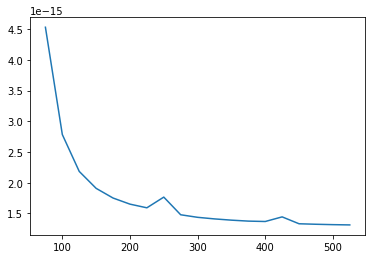

In [6]:
plt.plot(freqs/THz, N)

In [7]:
# h_LN = file['h_LN']
# h_etch = file['h_etch']
# width_top = file['width_top']
# theta = file['theta']
# h_slab = h_LN - h_etch
# w_ridge_base = width_top + 2*h_etch/np.tan(theta*pi/180)

# print('slab thickness = %.1f nm' %(h_slab/nm))
# print('width at the base = %.3f um' %(w_ridge_base/um))

# wavelength = file['wavelength']
# M = file['M']
# neff = file['neff']
# tepf = file['tepf']
# N = file['Norm']

# M = M.item(0)

## Overlap integrals

Nonlinear susceptibility tensor

In [8]:
d31 = -4.6*pm
d22 = 2.2*pm
d33 = -25*pm
d = np.array([[0, 0, 0, 0, d31, -d22], [-d22, d22, 0, d31, 0, 0], [d31, d31, d33, 0, 0, 0]])
print(d)

[[ 0.0e+00  0.0e+00  0.0e+00  0.0e+00 -4.6e-12 -2.2e-12]
 [-2.2e-12  2.2e-12  0.0e+00 -4.6e-12  0.0e+00  0.0e+00]
 [-4.6e-12 -4.6e-12 -2.5e-11  0.0e+00  0.0e+00  0.0e+00]]


In [9]:
def permute_axes(A):
    Bx = A.y
    By = A.z
    Bz = A.x
    return lum.field_2D(A.xx, A.yy, Bx, By, Bz)

In [41]:
def X_func(Ea,Eb,Ec):
    
    #Need to map lumerical coordinate system to crystal axes
    z = Ea.xx #Horizontal Z-crystal
    x = Ea.yy #Vertical X-crystal
    
    E1 = permute_axes(Ea)
    E2 = permute_axes(Eb)
    E3 = permute_axes(Ec)
    
    P_x = 2*d[0,4]*(E2.z*E3.x + E3.z*E2.x) + 2*d[0,5]*(E2.x*E3.y + E3.x*E2.y)
    P_y = 2*d[1,0]*E2.x*E3.x + 2*d[1,1]*E2.y*E3.y + 2*d[1,3]*(E2.z*E3.y + E3.z*E2.y)
    P_z = 2*d[2,0]*E2.x*E3.x + 2*d[2,1]*E2.y*E3.y + 2*d[2,2]*E2.z*E3.z
    P = lum.field_2D(z, x, P_x, P_y, P_z)
#     print('E1 max sq = ', np.amax(E1.magsq()))
#     print('E2 max sq = ', np.amax(E2.magsq()))
#     print('E3 max sq = ', np.amax(E3.magsq()))
#     print('P max sq = ', np.amax(P.magsq()))
    
    integrand = P.dot(E1.conj())
#     print('Integrand max abs = ', np.amax(abs(integrand)))
    
    return epsilon_0*simps(simps(integrand, x), z)
#     return simps(simps(integrand, x), z)

In [11]:
def get_field(f0, margin=10e9):
    for filename in os.listdir(data_directory):
        if filename.endswith(".npz"):
            data_filename = os.path.join(data_directory, filename)
            file = np.load(data_filename, allow_pickle=True)
            freq = c/file['wavelength']
            if abs(freq-f0)<margin:
                print('Found file: ', filename)
                M = file['M'].item(0)
                return M.E

In [29]:
f = 200*THz #Main frequency
fprime = 400*THz
fdelta = f - fprime

E1 = get_field(f)
E2 = get_field(fprime)
E3 = get_field(abs(fdelta))

N1 = N[freqs==f]
N2 = N[freqs==fprime]
N3 = N[freqs==abs(fdelta)]

E1.rescale(1/np.sqrt(N1))
E2.rescale(1/np.sqrt(N2))
E3.rescale(1/np.sqrt(N3))

Found file:  LNoI_700nm_340nm_width_1850nm_wl_1499_mode_1.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_749_mode_3.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_1499_mode_1.npz


In [30]:
X_func(E1, E2, E3)

E1 max sq =  605486921231838.8
E2 max sq =  730533121682206.8
E3 max sq =  605486921231838.8
P max sq =  1105175345.6723325
Integrand max abs =  817917819739.7555


(-2.8703204354042467e-12-7.108299827201069e-29j)

In [31]:
X_func(E1, E2.conj(), E3)

E1 max sq =  605486921231838.8
E2 max sq =  730533121682206.8
E3 max sq =  605486921231838.8
P max sq =  1105175345.6723325
Integrand max abs =  817917819739.7555


(-2.8703204354042467e-12+7.106799869440528e-29j)

In [43]:
X = np.zeros(freqs.size)
f = 200*THz #Main frequency

for kf in np.arange(freqs.size):
    fprime = freqs[kf]
    fdelta = f - fprime
    
    if abs(fdelta) in freqs:
    
        E1 = get_field(f)
        E2 = get_field(fprime)
        E3 = get_field(abs(fdelta))

        N1 = N[freqs==f]
        N2 = N[freqs==fprime]
        N3 = N[freqs==abs(fdelta)]

        E1.rescale(1/np.sqrt(N1))
        E2.rescale(1/np.sqrt(N2))
        E3.rescale(1/np.sqrt(N3))

        X[kf] = np.real(X_func(E1, E2, E3))
        print('')

Found file:  LNoI_700nm_340nm_width_1850nm_wl_1499_mode_1.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_3997_mode_0.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_2398_mode_0.npz

Found file:  LNoI_700nm_340nm_width_1850nm_wl_1499_mode_1.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_2997_mode_0.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_2997_mode_0.npz

Found file:  LNoI_700nm_340nm_width_1850nm_wl_1499_mode_1.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_2398_mode_0.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_3997_mode_0.npz

Found file:  LNoI_700nm_340nm_width_1850nm_wl_1499_mode_1.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_1090_mode_2.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_3997_mode_0.npz

Found file:  LNoI_700nm_340nm_width_1850nm_wl_1499_mode_1.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_999_mode_2.npz
Found file:  LNoI_700nm_340nm_width_1850nm_wl_2997_mode_0.npz

Found file:  LNoI_700nm_340nm_width_1850nm_wl_1499_mode_1.npz
Foun

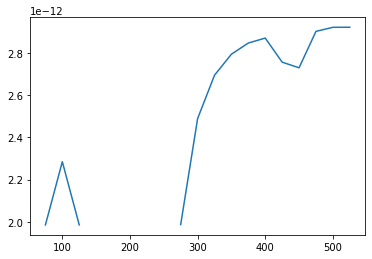

In [48]:
X[X==0]=np.nan
plt.plot(freqs/THz, abs(X))

We now map the xyz Lumerical coordinates to the crystal XYZ
x -> Z
y -> X
z -> Y

In [ ]:
z = M1.E.xx
x = M1.E.yy

Ew = lum.field_2D(z, x, M2.E.y, M2.E.z, M2.E.x)
E2w = lum.field_2D(z, x, M1.E.y, M1.E.z, M1.E.x)

In [ ]:
[Z,X] = np.meshgrid(z, x, indexing='ij')
plt.rcParams['figure.figsize'] = [16, 6]
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.pcolormesh(Z*1e6, X*1e6, Ew.magsq(), cmap=cm.jet)
ax2.pcolormesh(Z*1e6, X*1e6, E2w.magsq(), cmap=cm.jet)
ax1.axis('equal')
ax2.axis('equal')

In [ ]:
P2w_x = 2*epsilon_0*d[0,4]*2*Ew.z*Ew.x + 2*epsilon_0*d[0,5]*2*Ew.x*Ew.y
P2w_y = 2*epsilon_0*d[1,0]*Ew.x*Ew.x + 2*epsilon_0*d[1,1]*Ew.y*Ew.y + 2*epsilon_0*d[1,3]*2*Ew.z*Ew.y 
P2w_z = 2*epsilon_0*d[2,0]*Ew.x*Ew.x + 2*epsilon_0*d[2,1]*Ew.y*Ew.y + 2*epsilon_0*d[2,2]*Ew.z*Ew.z

P2w = lum.field_2D(z, x, P2w_x, P2w_y, P2w_z)

In [ ]:
plt.rcParams['figure.figsize'] = [16, 4]
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.pcolormesh(Z*1e6, X*1e6, np.abs(P2w.x), cmap=cm.jet)
ax2.pcolormesh(Z*1e6, X*1e6, np.abs(P2w.y), cmap=cm.jet)
ax3.pcolormesh(Z*1e6, X*1e6, np.abs(P2w.z), cmap=cm.jet)
ax1.axis('equal')
ax2.axis('equal')
ax3.axis('equal')

In [ ]:
integrand = P2w.dot(E2w)

plt.rcParams['figure.figsize'] = [16, 6]
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.pcolormesh(Z*1e6, X*1e6, np.real(integrand), cmap=cm.jet)
ax2.pcolormesh(Z*1e6, X*1e6, np.imag(integrand), cmap=cm.jet)
ax1.axis('equal')
ax2.axis('equal')

In [ ]:
X2w = simps(simps(integrand, x), z)
X2w

In [ ]:
N2w

In [ ]:
N2w = M1.N()
np.abs(X2w)*(2*pi*300*THz)/(4*N2w)

Order of magnitude check

In [ ]:
chi2 = 2*20*pm
k = (2*pi*300*THz)*chi2/(4*2*c)
print(k)